<a href="https://colab.research.google.com/github/mcvlix/lorenz-96-hybrid-esn/blob/main/rcesn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# === Mount your Drive ===
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tqdm import tqdm
from tqdm import trange
import torch
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse import linalg
from pathlib import Path
import gc
import pickle

In [4]:
# === Paths ===
project_path = '/content/drive/My Drive/AM170B Project'
data_path = os.path.join(project_path, 'data')
states_path = os.path.join(project_path, 'states')
checkpoints_path = os.path.join(project_path, 'checkpoints')
models_path = os.path.join(project_path, 'models')
os.makedirs(states_path, exist_ok=True)
os.makedirs(checkpoints_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)

In [5]:
os.listdir(project_path)

['rcesn.ipynb',
 'data',
 'checkpoints',
 'states',
 'models',
 'old_rcesn.ipynb',
 'hybrid_rcesn.ipynb']

In [6]:
def whos_memory(namespace):
    exclude = {
        'np', 'pd', 'plt', 'os', 'gc', 'sys', 'sio', 'tqdm', 'torch', 'sparse', 'Path',
        'exit', 'quit', 'open', 'get_ipython', 'whos_memory'
    }
    print(f"{'Variable':20} {'Type':15} {'Size (MB)':>10}")
    print("-" * 50)
    for name, val in namespace.items():
        if name.startswith("_") or name in exclude:
            continue
        try:
            size = sys.getsizeof(val) / 1024 / 1024
            print(f"{name:20} {type(val).__name__:15} {size:10.4f}")
        except Exception:
            print(f"{name:20} {type(val).__name__:15} {'<unknown>'}")

def delete_variables(namespace):
    # Safe exclusions: libraries, system functions, your own helpers
    exclude = {
        # Standard libs
        'np', 'pd', 'plt', 'os', 'gc', 'sys', 'sio', 'tqdm', 'trange', 'torch', 'sparse', 'Path',
        # IPython internals
        'get_ipython', 'exit', 'quit', 'open', 'In', 'Out',
        # User-defined helpers
        'whos_memory', 'delete_variables'
    }

    for name in list(namespace):
        if name.startswith("_") or name.startswith("__") or name in exclude:
            continue
        try:
            del namespace[name]
        except Exception as e:
            print(f"Could not delete {name}: {e}")

    gc.collect()
    print("Deleted user variables and collected garbage.")

# Run it like this:
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0001
Out                  dict                0.0002
drive                module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
delete_variables     function            0.0001


In [7]:
# === Parameters ===
shift_k = 0  # Start index for initial condition
approx_res_size = 5000

model_params = {
    'tau': 0.25,
    'nstep': 1000,
    'N': 8,
    'd': 22
}

res_params = {
    'radius': 0.1,
    'degree': 3,
    'sigma': 0.5,
    'train_length': 500000,
    'N': int(np.floor(approx_res_size / model_params['N']) * model_params['N']),
    'num_inputs': model_params['N'],
    'predict_length': 1000,
    'beta': 0.0001
}

In [8]:
# === Reservoir Utilities ===
def generate_reservoir(size, radius, degree):
    print("Generating Reservoir")
    sparsity = degree / float(size)
    A = sparse.rand(size, size, density=sparsity).todense()
    eigvals = np.linalg.eigvals(A)
    A = (A / np.max(np.abs(eigvals))) * radius
    return A

def build_input_weights(N, num_inputs, sigma):
    q = int(N / num_inputs)
    Win = np.zeros((N, num_inputs))
    for i in range(num_inputs):  # Removed tqdm
        np.random.seed(i)
        Win[i * q: (i + 1) * q, i] = sigma * (-1 + 2 * np.random.rand(q))
    return Win

def reservoir_layer(A, Win, data, res_params, start_step=1, states=None):
    N, T = res_params['N'], res_params['train_length']
    if states is None:
        states = np.zeros((N, T))
    for i in trange(start_step - 1, T - 1, desc="Training reservoir"):
        states[:, i + 1] = np.tanh(np.dot(A, states[:, i]) + np.dot(Win, data[:, i]))
        # if (i + 1) % 10000 == 0:
        #     save_checkpoint(states[:, :i + 1], A, Win, i + 1)
    return states

def train(res_params, states, data):
    beta = res_params['beta']
    idenmat = beta * sparse.identity(res_params['N'])
    states2 = states.copy()
    for j in trange(2, states2.shape[0] - 2, desc="Training Wout"):
        if j % 2 == 0:
            states2[j, :] = states[j - 1, :] * states[j - 2, :]
    U = np.dot(states2, states2.T) + idenmat
    Wout = np.dot(np.linalg.inv(U), np.dot(states2, data.T))
    return Wout.T

def predict(A, Win, res_params, x, Wout):
    output = np.zeros((res_params['num_inputs'],res_params['predict_length']))
    for i in tqdm(range(res_params['predict_length']), desc="Predicting"):
        x_aug = x.copy()
        for j in range(2,np.shape(x_aug)[0]-2):
            if (np.mod(j,2)==0):
                x_aug[j] = (x[j-1]*x[j-2]).copy()
        out = np.squeeze(np.asarray(np.dot(Wout,x_aug)))
        output[:,i] = out
        x1 = np.tanh(np.dot(A,x) + np.dot(Win,out))
        x = np.squeeze(np.asarray(x1))
    return output, x

# def save_checkpoint(states, A, Win, step):
#     checkpoint = {
#         'states': states,
#         'A': A,
#         'Win': Win,
#         'step': step
#     }
#     filename = os.path.join(SAVE_DIR, 'reservoir_checkpoint.pt')
#     torch.save(checkpoint, filename, pickle_protocol=4)
#     print(f"Saved checkpoint at step {step}: {filename}")

# def load_latest_checkpoint():
#     path = os.path.join(SAVE_DIR, 'reservoir_checkpoint.pt')
#     if not os.path.exists(path):
#         print("No checkpoint found. Starting fresh.")
#         return None
#     # with open(path, 'rb') as f:
#     #     checkpoint = pickle.load(f)
#     checkpoint = torch.load(path)
#     print(f"Resuming from checkpoint at step {checkpoint['step']}")
#     return checkpoint

# def save_model(A, Win, Wout, final_state):
#     model = {
#         'A': A,
#         'Win': Win,
#         'Wout': Wout,
#         'final_state': final_state
#     }
#     torch.save(model, os.path.join(SAVE_DIR, 'trained_reservoir_model.pt'), pickle_protocol=4)
#     print("Full model saved.")

In [9]:
def reservoir_layer_chunked(A, Win, data_chunk, res_params, prev_state=None, chunk_idx=0, num_chunks=0):
    """
    Process one chunk of data and save the reservoir states.
    data_chunk: shape (num_inputs, chunk_size)
    """
    N, T = res_params['N'], data_chunk.shape[1]
    states = np.zeros((N, T))

    if prev_state is not None:
        states[:, 0] = prev_state

    for t in trange(1, T, desc=f"Processing Chunk: {chunk_idx}/{num_chunks}"):
      states[:, t] = np.tanh(A @ states[:, t - 1] + Win @ data_chunk[:, t - 1])

    # Save to .npz
    filename = os.path.join(states_path, f'states_chunk_{chunk_idx:03d}.npz')
    np.savez_compressed(filename, states=states, inputs=data_chunk)
    gc.collect()

    return states[:, -1]  # Return final state to continue chain

In [10]:
def safe_process_chunks(npy_path, res_params, chunk_size=50000, checkpoint_file=None):
    print("Starting chunked training with memory-mapped loading...")

    data = np.load(npy_path, mmap_mode='r')
    total_steps = res_params['train_length']
    num_chunks = total_steps // chunk_size
    num_inputs = res_params['num_inputs']

    # === Load or Initialize Model ===
    if checkpoint_file and os.path.exists(checkpoint_file):
        print(f"Resuming from checkpoint: {checkpoint_file}")
        checkpoint = np.load(checkpoint_file)
        A = checkpoint['A']
        Win = checkpoint['Win']
        processed_chunks = int(checkpoint_file.split('_')[-1].split('.')[0]) // chunk_size

        state_file = os.path.join(states_path, f'states_chunk_{processed_chunks - 1:03d}.npz')
        if os.path.exists(state_file):
            prev_state = np.load(state_file)['states'][:, -1]
            print(f"Restored last state from {state_file}")
        else:
            raise FileNotFoundError(f"Missing state file for chunk {processed_chunks - 1}")
    else:
        print("Starting fresh. Generating new reservoir and input weights.")
        A = generate_reservoir(res_params['N'], res_params['radius'], res_params['degree'])
        Win = build_input_weights(res_params['N'], num_inputs, res_params['sigma'])
        processed_chunks = 0

    # === Loop Over Chunks ===
    for i in range(processed_chunks, num_chunks):
        start, end = i * chunk_size, (i + 1) * chunk_size
        chunk_data = data[start:end, :num_inputs].T  # shape: (num_inputs, chunk_size)
        prev_state = reservoir_layer_chunked(A, Win, chunk_data, res_params, prev_state, chunk_idx=i, num_chunks=num_chunks)

        # Checkpointing
        if (i + 1) % 2 == 0:
            step = (i + 1) * chunk_size
            ckpt_path = os.path.join(checkpoints_path, f'checkpoint_{step}.npz')
            np.savez_compressed(ckpt_path, A=A, Win=Win)
            print(f"Saved checkpoint: {ckpt_path}")
            gc.collect()

    print("\nAll chunks processed.")
    return A, Win, prev_state, num_chunks


In [11]:
def get_latest_checkpoint_step(checkpoints_path):
    ckpts = [f for f in os.listdir(checkpoints_path) if f.startswith('checkpoint_') and f.endswith('.npz')]
    if not ckpts:
        raise ValueError("No checkpoints found.")
    steps = [int(f.split('_')[-1].split('.')[0]) for f in ckpts]
    return max(steps)

def load_states_up_to_checkpoint(states_path, checkpoint_step, chunk_size):
    state_list = []
    input_list = []

    max_chunk = checkpoint_step // chunk_size
    for i in trange(max_chunk):
        file = f'states_chunk_{i:03d}.npz'
        full_path = os.path.join(states_path, file)
        if not os.path.exists(full_path):
            print(f"Warning: Missing {file}")
            continue
        data = np.load(full_path)
        state_list.append(data['states'])
        input_list.append(data['inputs'])
        data.close()
        gc.collect()

    full_states = np.hstack(state_list)
    full_inputs = np.hstack(input_list)
    return full_states, full_inputs

In [12]:
def predict_esn(A, Win, res_params, last_state, W_out, initial_output):
    """
    Predict future dynamics using the trained ESN model.
    - last_state: final state from training (N,)
    - initial_output: last known input (num_inputs,) to bootstrap prediction
    Returns:
        - predictions: shape (num_inputs, predict_length)
    """
    N = res_params['N']
    num_inputs = res_params['num_inputs']
    T = res_params['predict_length']

    x = last_state.copy()
    output = np.zeros((num_inputs, T))
    out = initial_output.copy()

    for t in tqdm(range(T), desc="Predicting"):
        # Augment state for nonlinear transformation
        x_aug = x.copy()
        for j in range(2, len(x_aug) - 2):
            if j % 2 == 0:
                x_aug[j] = x[j - 1] * x[j - 2]

        out = np.dot(W_out, x_aug).squeeze()
        output[:, t] = out
        x = np.tanh(A @ x + Win @ out)

    return output

In [13]:
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
drive                module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
delete_variables     function            0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
generate_reservoir   function            0.0001
build_input_weights  function            0.0001
reservoir_layer      function        

In [ ]:
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
# checkpoint_file = os.path.join(checkpoints_path, 'checkpoint_1000.npz')

In [ ]:
A, Win, last_state, num_chunks = safe_process_chunks(
    npy_path=npy_path,
    res_params=res_params,
    chunk_size=50000,
    checkpoint_file=None  # Resume from here
)

Starting chunked training with memory-mapped loading...
Starting fresh. Generating new reservoir and input weights.
Generating Reservoir


Processing Chunk: 1/10: 100%|██████████| 49999/49999 [17:14<00:00, 48.34it/s]


Saved checkpoint: /content/drive/My Drive/AM170B Project/checkpoints/checkpoint_100000.npz


Processing Chunk: 3/10: 100%|██████████| 49999/49999 [17:21<00:00, 48.01it/s]


Saved checkpoint: /content/drive/My Drive/AM170B Project/checkpoints/checkpoint_200000.npz


Processing Chunk: 5/10: 100%|██████████| 49999/49999 [17:15<00:00, 48.28it/s]


Saved checkpoint: /content/drive/My Drive/AM170B Project/checkpoints/checkpoint_300000.npz


Processing Chunk: 7/10: 100%|██████████| 49999/49999 [17:19<00:00, 48.12it/s]


Saved checkpoint: /content/drive/My Drive/AM170B Project/checkpoints/checkpoint_400000.npz


Processing Chunk: 9/10: 100%|██████████| 49999/49999 [18:07<00:00, 45.96it/s]


Saved checkpoint: /content/drive/My Drive/AM170B Project/checkpoints/checkpoint_500000.npz

All chunks processed.


In [14]:
# ===  Free memory ===
# del A, Win, last_state, num_chunks
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
drive                module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
delete_variables     function            0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
generate_reservoir   function            0.0001
build_input_weights  function            0.0001
reservoir_layer      function        

In [15]:
checkpoint_file = os.path.join(checkpoints_path, 'checkpoint_500000.npz')
checkpoint_step = get_latest_checkpoint_step(checkpoints_path)
# checkpoint_step = 500000
states, inputs = load_states_up_to_checkpoint(states_path, checkpoint_step, chunk_size=50000)
print("Loaded shapes:", states.shape, inputs.shape)

100%|██████████| 10/10 [04:02<00:00, 24.28s/it]


Loaded shapes: (5000, 500000) (8, 500000)


In [18]:
W_out = train(res_params, states, inputs)

Training Wout: 100%|██████████| 4996/4996 [00:01<00:00, 2519.97it/s]


In [19]:
# Reload A and Win from latest checkpoint
ckpt_file = os.path.join(checkpoints_path, f'checkpoint_{checkpoint_step}.npz')
ckpt = np.load(checkpoint_file)
A = ckpt['A']
Win = ckpt['Win']
ckpt.close()

# Save final model
model_file = os.path.join(models_path, f'model_{checkpoint_step}.npz')
np.savez_compressed(model_file, A=A, Win=Win, W_out=W_out)
print(f"Saved final model to {model_file}")

Saved final model to /content/drive/My Drive/AM170B Project/models/model_500000.npz


In [20]:
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')

In [24]:
# Load model
model = np.load(os.path.join(models_path, 'model_500000.npz'))
A = model['A']
Win = model['Win']
W_out = model['W_out']

# Prediction config
res_params['predict_length'] = 1000
start = 500000  # start prediction immediately after training

# Load data and initial input
data = np.load(npy_path, mmap_mode='r')
X_true = data[start:start + res_params['predict_length'], :res_params['num_inputs']].T
initial_output = data[start - 1, :res_params['num_inputs']]

# Load final reservoir state from last training chunk
last_state_file = os.path.join(states_path, f'states_chunk_009.npz')  # 10th chunk (index 0–9)
last_state = np.load(last_state_file)['states'][:, -1]

# Run prediction
X_pred = predict_esn(A, Win, res_params, last_state, W_out, initial_output)
X_diff = X_true - X_pred

Predicting: 100%|██████████| 1000/1000 [00:06<00:00, 161.27it/s]


In [25]:
predictions_path = os.path.join(project_path, 'predictions')
os.makedirs(predictions_path, exist_ok=True)

In [26]:
np.savez_compressed(
    os.path.join(predictions_path, f'prediction_start{start}_len{res_params["predict_length"]}.npz'),
    X_true=X_true,
    X_pred=X_pred,
    X_diff=X_diff,
    start=start,
    length=res_params['predict_length']
)


In [28]:
# === Add to path setup ===
plots_path = os.path.join(project_path, 'plots')
os.makedirs(plots_path, exist_ok=True)


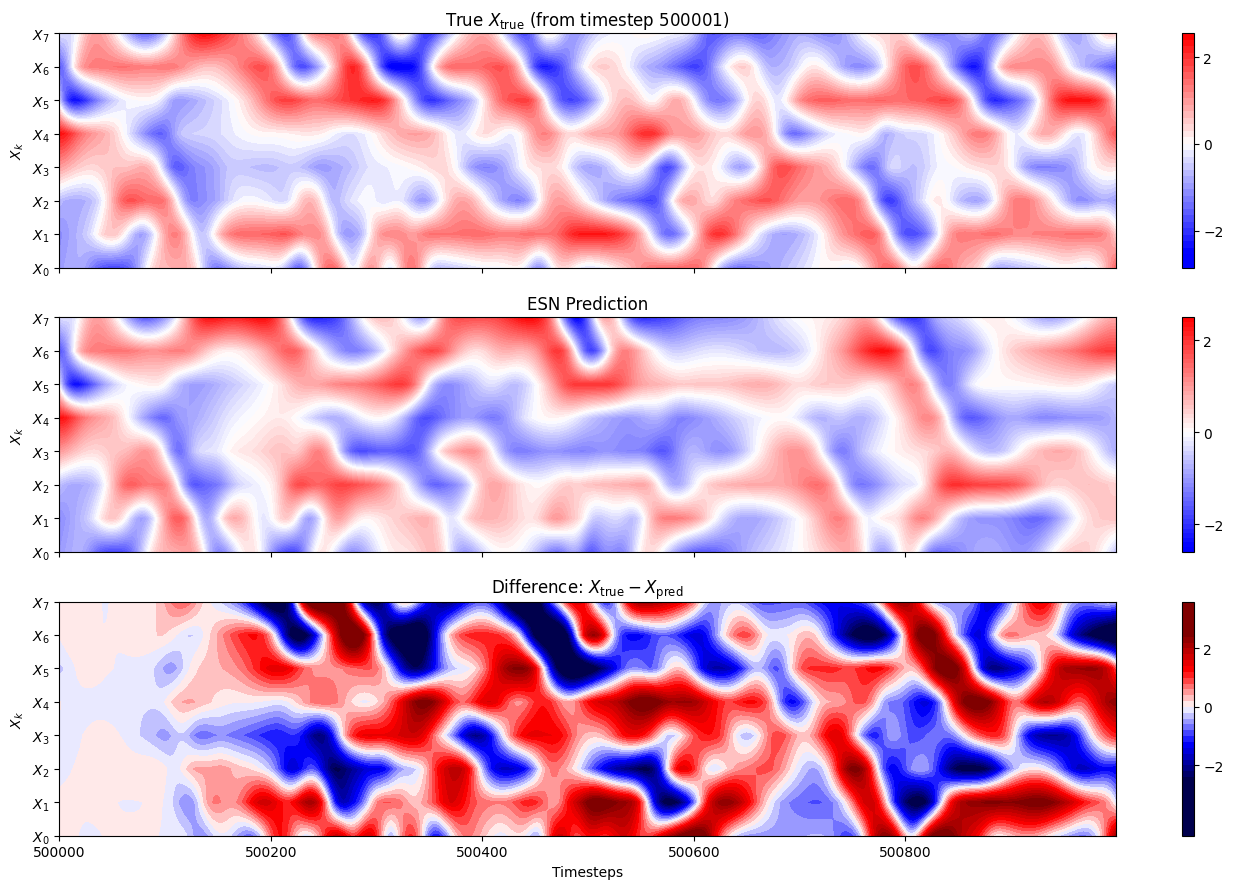

✅ Saved plot to /content/drive/My Drive/AM170B Project/plots/prediction_plot_start500000_len1000.png


In [29]:
# === Plotting ===
time_axis = np.arange(start, start + res_params['predict_length'])
space_axis = np.arange(res_params['num_inputs'])

fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# --- True ---
c1 = axs[0].contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
axs[0].set_title("True $X_{\\mathrm{true}}$ (from timestep 500001)")
axs[0].set_ylabel("$X_k$")
axs[0].set_yticks(space_axis)
axs[0].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb1 = fig.colorbar(c1, ax=axs[0])
cb1.set_ticks([-2, 0, 2])

# --- Predicted ---
c2 = axs[1].contourf(time_axis, space_axis, X_pred, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
axs[1].set_title("ESN Prediction")
axs[1].set_ylabel("$X_k$")
axs[1].set_yticks(space_axis)
axs[1].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb2 = fig.colorbar(c2, ax=axs[1])
cb2.set_ticks([-2, 0, 2])

# --- Difference ---
c3 = axs[2].contourf(time_axis, space_axis, X_diff, levels=50, cmap='seismic', vmin=-2.5, vmax=2.5)
axs[2].set_title("Difference: $X_{\\mathrm{true}} - X_{\\mathrm{pred}}$")
axs[2].set_xlabel("Timesteps")
axs[2].set_ylabel("$X_k$")
axs[2].set_yticks(space_axis)
axs[2].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb3 = fig.colorbar(c3, ax=axs[2])
cb3.set_ticks([-2, 0, 2])

# === Save plot ===
plot_filename = f'prediction_plot_start{start}_len{res_params["predict_length"]}.png'
plt.tight_layout()
plt.savefig(os.path.join(plots_path, plot_filename), dpi=300)
plt.show()

print(f"✅ Saved plot to {os.path.join(plots_path, plot_filename)}")
